In [219]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [220]:
#export
from utils.nb_functions import *
from utils.nb_classes_l8_to_10 import *
torch.set_num_threads(2)

In [221]:
#partial example
def f(a, b, c, x): 
    return 1000*a + 100*b + 10*c + x 
  
# A partial function that calls f with 
# a as 3, b as 1 and c as 4. 
g = partial(f, 3, 1, 4) 
  
# Calling g() 
print(g(5)) 


3145


Go to Lesson 10 at 1:00:45

## ConvNet

In [222]:
x_train,y_train,x_valid,y_valid = get_data()

Helper function to quickly normalize with the mean and standard deviation from our training set:

In [223]:
#export
def normalize_to(train, valid):
    m,s = train.mean(),train.std()
    return normalize(train, m, s), normalize(valid, m, s)

In [224]:
x_train,x_valid = normalize_to(x_train,x_valid)
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)

Let's check it behaved properly.

In [225]:
x_train.mean(),x_train.std()

(tensor(3.0614e-05), tensor(1.))

In [226]:
nh,bs = 50,512
c = y_train.max().item()+1
loss_func = F.cross_entropy

data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [227]:
??DataBunch

To refactor layers, it's useful to have a `Lambda` layer that can take a basic function and convert it to a layer you can put in `nn.Sequential`.

NB: if you use a Lambda layer with a lambda function, your model won't pickle so you won't be able to save it with PyTorch. So it's best to give a name to the function you're using inside your Lambda (like flatten below).

In [228]:
#export
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x): 
        print(f'func: {self.func}')
        val = self.func(x)
        print(f'in shape: {x.shape}, out shape: {val.shape}')
        return val

#remove 1,1 axis after after adaptive average pooling
def flatten(x):      
    return x.view(x.shape[0], -1)

This one takes the flat vector of size `bs x 784` and puts it back as a batch of images of 28 by 28 pixels
-1 as bs remains as per whatever it was before

In [229]:
def mnist_resize(x): 
    return x.view(-1, 1, 28, 28)

We can now define a simple CNN.

Conv2d args:

        in_channels (int): Number of channels in the input image
        out_channels (int): Number of channels produced by the convolution
        kernel_size (int or tuple): Size of the convolving kernel
        stride (int or tuple, optional): Stride of the convolution. Default: 1
        padding (int or tuple, optional): Zero-padding added to both sides of the input. Default: 0
        padding_mode (string, optional). Accepted values `zeros` and `circular` Default: `zeros`
        dilation (int or tuple, optional): Spacing between kernel elements. Default: 1
        groups (int, optional): Number of blocked connections from input channels to output channels. Default: 1
        bias (bool, optional): If ``True``, adds a learnable bias to the output. Default: ``True``

In [230]:
def get_cnn_model(data):
    return nn.Sequential(
        Lambda(mnist_resize),
        nn.Conv2d( 1, 8, 5, padding=2,stride=2), nn.ReLU(), #output size=14 (stride 2, input is 28)
        nn.Conv2d( 8,16, 3, padding=1,stride=2), nn.ReLU(), # 7
        nn.Conv2d(16,32, 3, padding=1,stride=2), nn.ReLU(), # 4
        nn.Conv2d(32,32, 3, padding=1,stride=2), nn.ReLU(), # 2
        nn.AdaptiveAvgPool2d(1),
        #nn.MaxPool2d(1),
        Lambda(flatten),
        nn.Linear(32,data.c)
    )

In [231]:
model = get_cnn_model(data)

Basic callbacks from the previous notebook:

In [232]:
cbfs = [Recorder, partial(AvgStatsCallback,accuracy)]

In [233]:
opt = optim.SGD(model.parameters(), lr=0.4)
learn = Learner(model, opt, loss_func, data)
run = Runner(cb_funcs=cbfs)

In [234]:
%time run.fit(1, learn)

func: <function mnist_resize at 0x7f16681a36a8>
in shape: torch.Size([512, 784]), out shape: torch.Size([512, 1, 28, 28])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function mnist_resize at 0x7f16681a36a8>
in shape: torch.Size([512, 784]), out shape: torch.Size([512, 1, 28, 28])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function mnist_resize at 0x7f16681a36a8>
in shape: torch.Size([512, 784]), out shape: torch.Size([512, 1, 28, 28])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function mnist_resize at 0x7f16681a36a8>
in shape: torch.Size([512, 784]), out shape: torch.Size([512, 1, 28, 28])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function mnist_resize at 0x7f16681a36a8>
in s

func: <function mnist_resize at 0x7f16681a36a8>
in shape: torch.Size([512, 784]), out shape: torch.Size([512, 1, 28, 28])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function mnist_resize at 0x7f16681a36a8>
in shape: torch.Size([512, 784]), out shape: torch.Size([512, 1, 28, 28])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function mnist_resize at 0x7f16681a36a8>
in shape: torch.Size([512, 784]), out shape: torch.Size([512, 1, 28, 28])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function mnist_resize at 0x7f16681a36a8>
in shape: torch.Size([512, 784]), out shape: torch.Size([512, 1, 28, 28])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function mnist_resize at 0x7f16681a36a8>
in s

func: <function mnist_resize at 0x7f16681a36a8>
in shape: torch.Size([512, 784]), out shape: torch.Size([512, 1, 28, 28])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function mnist_resize at 0x7f16681a36a8>
in shape: torch.Size([512, 784]), out shape: torch.Size([512, 1, 28, 28])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function mnist_resize at 0x7f16681a36a8>
in shape: torch.Size([512, 784]), out shape: torch.Size([512, 1, 28, 28])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function mnist_resize at 0x7f16681a36a8>
in shape: torch.Size([512, 784]), out shape: torch.Size([512, 1, 28, 28])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function mnist_resize at 0x7f16681a36a8>
in s

## CUDA

This took a long time to run, so it's time to use a GPU. A simple Callback can make sure the model, inputs and targets are all on the same device.

NB Once we go to the GPU we loose ability to run debugger on the thread 

When put Model on GPU:

    Parameters: what are updating-what it stores

    Activations: what its calculating

    Inputs

    Data out of loss function

In [235]:
# Somewhat more flexible way
device = torch.device('cuda',0)

In [236]:
class CudaCallback(Callback):
    def __init__(self,device): 
        self.device=device
    def begin_fit(self): 
        self.model.to(device)
    def begin_batch(self): 
        self.run.xb,self.run.yb = self.xb.to(device),self.yb.to(device)

In [237]:
# Somewhat less flexible, but quite convenient
torch.cuda.set_device(device)

In [238]:
#export
class CudaCallback(Callback):
    def begin_fit(self): 
        self.model.cuda()
    def begin_batch(self): 
        self.run.xb,self.run.yb = self.xb.cuda(),self.yb.cuda()

In [239]:
cbfs.append(CudaCallback)

In [240]:
model = get_cnn_model(data)

In [241]:
opt = optim.SGD(model.parameters(), lr=0.4)
learn = Learner(model, opt, loss_func, data)
run = Runner(cb_funcs=cbfs)

In [242]:
%time run.fit(3, learn)

func: <function mnist_resize at 0x7f16681a36a8>
in shape: torch.Size([512, 784]), out shape: torch.Size([512, 1, 28, 28])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function mnist_resize at 0x7f16681a36a8>
in shape: torch.Size([512, 784]), out shape: torch.Size([512, 1, 28, 28])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function mnist_resize at 0x7f16681a36a8>
in shape: torch.Size([512, 784]), out shape: torch.Size([512, 1, 28, 28])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function mnist_resize at 0x7f16681a36a8>
in shape: torch.Size([512, 784]), out shape: torch.Size([512, 1, 28, 28])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function mnist_resize at 0x7f16681a36a8>
in s

func: <function mnist_resize at 0x7f16681a36a8>
in shape: torch.Size([512, 784]), out shape: torch.Size([512, 1, 28, 28])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function mnist_resize at 0x7f16681a36a8>
in shape: torch.Size([512, 784]), out shape: torch.Size([512, 1, 28, 28])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function mnist_resize at 0x7f16681a36a8>
in shape: torch.Size([512, 784]), out shape: torch.Size([512, 1, 28, 28])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function mnist_resize at 0x7f16681a36a8>
in shape: torch.Size([512, 784]), out shape: torch.Size([512, 1, 28, 28])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function mnist_resize at 0x7f16681a36a8>
in s

func: <function mnist_resize at 0x7f16681a36a8>
in shape: torch.Size([512, 784]), out shape: torch.Size([512, 1, 28, 28])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function mnist_resize at 0x7f16681a36a8>
in shape: torch.Size([512, 784]), out shape: torch.Size([512, 1, 28, 28])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function mnist_resize at 0x7f16681a36a8>
in shape: torch.Size([512, 784]), out shape: torch.Size([512, 1, 28, 28])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function mnist_resize at 0x7f16681a36a8>
in shape: torch.Size([512, 784]), out shape: torch.Size([512, 1, 28, 28])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function mnist_resize at 0x7f16681a36a8>
in s

func: <function mnist_resize at 0x7f16681a36a8>
in shape: torch.Size([512, 784]), out shape: torch.Size([512, 1, 28, 28])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function mnist_resize at 0x7f16681a36a8>
in shape: torch.Size([512, 784]), out shape: torch.Size([512, 1, 28, 28])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function mnist_resize at 0x7f16681a36a8>
in shape: torch.Size([512, 784]), out shape: torch.Size([512, 1, 28, 28])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function mnist_resize at 0x7f16681a36a8>
in shape: torch.Size([512, 784]), out shape: torch.Size([512, 1, 28, 28])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function mnist_resize at 0x7f16681a36a8>
in s

func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function mnist_resize at 0x7f16681a36a8>
in shape: torch.Size([512, 784]), out shape: torch.Size([512, 1, 28, 28])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function mnist_resize at 0x7f16681a36a8>
in shape: torch.Size([512, 784]), out shape: torch.Size([512, 1, 28, 28])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function mnist_resize at 0x7f16681a36a8>
in shape: torch.Size([512, 784]), out shape: torch.Size([512, 1, 28, 28])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function mnist_resize at 0x7f16681a36a8>
in shape: torch.Size([512, 784]), out shape: torch.Size([512, 1, 28, 28])
func: <function flatten at 0x7f16681a3d08>
in shape:

func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function mnist_resize at 0x7f16681a36a8>
in shape: torch.Size([512, 784]), out shape: torch.Size([512, 1, 28, 28])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function mnist_resize at 0x7f16681a36a8>
in shape: torch.Size([512, 784]), out shape: torch.Size([512, 1, 28, 28])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function mnist_resize at 0x7f16681a36a8>
in shape: torch.Size([512, 784]), out shape: torch.Size([512, 1, 28, 28])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function mnist_resize at 0x7f16681a36a8>
in shape: torch.Size([512, 784]), out shape: torch.Size([512, 1, 28, 28])
func: <function flatten at 0x7f16681a3d08>
in shape:

func: <function mnist_resize at 0x7f16681a36a8>
in shape: torch.Size([512, 784]), out shape: torch.Size([512, 1, 28, 28])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function mnist_resize at 0x7f16681a36a8>
in shape: torch.Size([512, 784]), out shape: torch.Size([512, 1, 28, 28])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function mnist_resize at 0x7f16681a36a8>
in shape: torch.Size([512, 784]), out shape: torch.Size([512, 1, 28, 28])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function mnist_resize at 0x7f16681a36a8>
in shape: torch.Size([512, 784]), out shape: torch.Size([512, 1, 28, 28])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function mnist_resize at 0x7f16681a36a8>
in s

Now, that's definitely faster!

## Refactor model

First we can regroup all the conv/relu in a single function:

In [243]:
def conv2d(ni, nf, ks=3, stride=2):
    return nn.Sequential(
        nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride), nn.ReLU())

Another thing is that we can do the mnist resize in a batch transform, that we can do with a Callback.


https://realpython.com/inner-functions-what-are-they-good-for/
What’s a Closure?

A closure simply causes the inner function to remember the state of its environment when called. 
Beginners often think that a closure is the inner function, but it’s really caused by the inner function. 
The closure “closes” the local variable on the stack, and this stays around after the stack creation has 
finished executing.


Callback to transform the independant variable (x) for a batch

In [244]:
#export
class BatchTransformXCallback(Callback):
    _order=2
    def __init__(self, tfm): 
        print(f'BatchTransformXCallback.__init__() tfm: {tfm}')
        self.tfm = tfm
    def begin_batch(self): 
        #replace batch with result of transformation function
        self.run.xb = self.tfm(self.xb)

def view_tfm(*size):
    def _inner(x): 
        return x.view(*((-1,)+size))
    return _inner

In [245]:
mnist_view = view_tfm(1,28,28)
cbfs.append(partial(BatchTransformXCallback, mnist_view))

With the `AdaptiveAvgPool`, this model can now work on any size input:

In [246]:
nfs = [8,16,32,32]

In [247]:
def get_cnn_layers(data, nfs):
    nfs = [1] + nfs
    return [
        #25 inputs for 8 outputs
        conv2d(nfs[i], nfs[i+1], 5 if i==0 else 3)
        for i in range(len(nfs)-1)
    ] + [nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], data.c)]

def get_cnn_model(data, nfs): return nn.Sequential(*get_cnn_layers(data, nfs))

And this helper function will quickly give us everything needed to run the training.

In [248]:
#export
def get_runner(model, data, lr=0.6, cbs=None, opt_func=None, loss_func = F.cross_entropy):
    if opt_func is None: 
        opt_func = optim.SGD
    opt = opt_func(model.parameters(), lr=lr)
    learn = Learner(model, opt, loss_func, data)
    return learn, Runner(cb_funcs=listify(cbs))

In [249]:
model = get_cnn_model(data, nfs)
learn,run = get_runner(model, data, lr=0.4, cbs=cbfs)

BatchTransformXCallback.__init__() tfm: <function view_tfm.<locals>._inner at 0x7f16684f5e18>


In [250]:
model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): AdaptiveAvgPool2d(output_size=1)
  (5): Lambda()
  (6): Linear(in_features=32, out_features=10, bias=True)
)

In [251]:
run.fit(3, learn)

func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1])

in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([336, 32, 1, 1]), out shape: torch.Size([336, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([1024, 32, 1, 1]), out shape: torch.Size([1024, 32])
func: 

func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1])

func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1])

func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([1024, 32, 1, 1]), out shape: torch.Size([1024, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([1024, 32, 1, 1]), out shape: torch.Size([1024, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([1024, 32, 1, 1]), out shape: torch.Size([1024, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([1024, 32, 1, 1]), out shape: torch.Size([1024, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([1024, 32, 1, 1]), out shape: torch.Size([1024, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([1024, 32, 1, 1]), out shape: torch.Size([1024, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([1024, 32, 1, 1]), out shape: torch.Size([1024, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([784, 32, 1, 1]), out shape: torch.Size([784, 32])
train: [0.20554986328125, tensor(0.9374, device='cuda:0')]
valid: 

## Hooks

### Manual insertion

Let's say we want to do some telemetry, and want the mean and standard deviation of each activations in the model. First we can do it manually like this:

In [252]:
class SequentialModel(nn.Module):
    def __init__(self, *layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        self.act_means = [[] for _ in layers]
        self.act_stds  = [[] for _ in layers]
        
    def __call__(self, x):
        for i,l in enumerate(self.layers):
            x = l(x)
            if self.training:
                self.act_means[i].append(x.data.mean())
                self.act_stds [i].append(x.data.std ())
        return x
    
    def __iter__(self): 
        return iter(self.layers)

In [253]:
model =  SequentialModel(*get_cnn_layers(data, nfs))
learn,run = get_runner(model, data, lr=0.9, cbs=cbfs)

BatchTransformXCallback.__init__() tfm: <function view_tfm.<locals>._inner at 0x7f16684f5e18>


In [254]:
run.fit(2, learn)

func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1])

func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1])

func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1])

Now we can have a look at the means and stds of the activations at the beginning of training.

For every layer the means get exp bigger untill they collapse

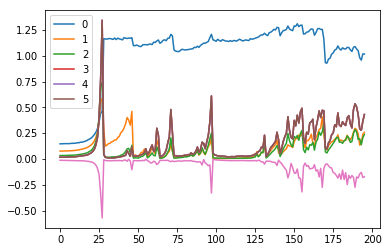

In [255]:
for l in model.act_means: 
    plt.plot(l)
plt.legend(range(6));

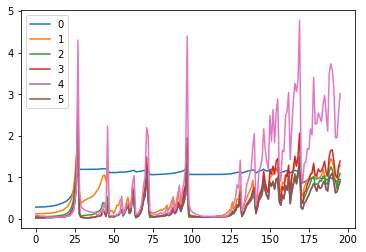

In [256]:
for l in model.act_stds: 
    plt.plot(l)
plt.legend(range(6));

Lets look at first 10

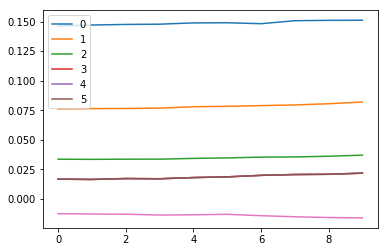

In [257]:
for l in model.act_means: 
    plt.plot(l[:10])
plt.legend(range(6));

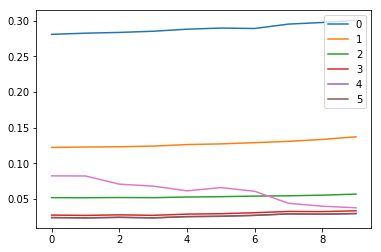

In [258]:
for l in model.act_stds: 
    plt.plot(l[:10])
plt.legend(range(6));

Final layers getting no activations/gradients

### Pytorch hooks

Hooks are PyTorch object you can add to any nn.Module. A hook will be called when a layer, it is registered to, is executed during the forward pass (forward hook) or the backward pass (backward hook).

Hooks don't require us to rewrite the model.

In [259]:
model = get_cnn_model(data, nfs)
learn,run = get_runner(model, data, lr=0.5, cbs=cbfs)

BatchTransformXCallback.__init__() tfm: <function view_tfm.<locals>._inner at 0x7f16684f5e18>


In [260]:
act_means = [[] for _ in model]
act_stds  = [[] for _ in model]

A hook is attached to a layer, and needs to have a function that takes three arguments: module, input, output. Here we store the mean and std of the output in the correct position of our list.

In [261]:
#here we use i for layer number and use a partial to specify this value
def append_stats(i, mod, inp, outp):
    if mod.training:
        act_means[i].append(outp.data.mean())
        act_stds [i].append(outp.data.std())

Here we register a forward (or could alt register backward hook) hook/callback/event
calls the function when forward pass is run


register_forward_hook(hook)

    The hook will be called every time after forward() has computed an output. It should have the following signature:

    hook(module, input, output) -> None

    The hook should not modify the input or output.

    Returns:
        a handle that can be used to remove the added hook by calling handle.remove()
    Return type:
        torch.utils.hooks.RemovableHandle



In [262]:
for i,m in enumerate(model): 
    #only supplying part of append_stats, I presume pytorch much supply the other 3 parameters
    m.register_forward_hook(partial(append_stats, i))

In [263]:
run.fit(1, learn)

func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1])

func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1])

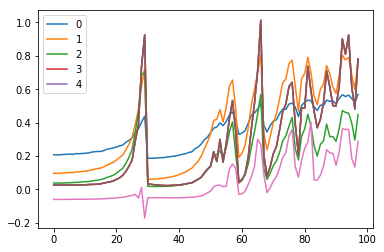

In [264]:
for o in act_means: 
    plt.plot(o)
plt.legend(range(5));

### Hook class

We can refactor this in a Hook class. It's very important to remove the hooks when they are deleted, otherwise there will be references kept and the memory won't be properly released when your model is deleted.

Keep state inside the hook class

In [265]:
#export
def children(m): 
    return list(m.children())

class Hook():
    def __init__(self, m, f): 
        #note we call self with partial
        self.hook = m.register_forward_hook(partial(f, self))
    def remove(self): 
        self.hook.remove()
    def __del__(self): 
        self.remove()

def append_stats(hook, mod, inp, outp):
    if not hasattr(hook,'stats'): 
        #lists to store means and std devs
        hook.stats = ([],[])
    means,stds = hook.stats
    if mod.training:
        means.append(outp.data.mean())
        stds .append(outp.data.std())

NB: In fastai we use a `bool` param to choose whether to make it a forward or backward hook. In the above version we're only supporting forward hooks.

In [266]:
model = get_cnn_model(data, nfs)
learn,run = get_runner(model, data, lr=0.5, cbs=cbfs)

BatchTransformXCallback.__init__() tfm: <function view_tfm.<locals>._inner at 0x7f16684f5e18>


In [267]:
#conv layers are most interesting, not interested in linear layers so just grab first few

In [268]:
hooks = [Hook(l, append_stats) for l in children(model[:4])]

In [269]:
run.fit(1, learn)

func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1])

func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1])

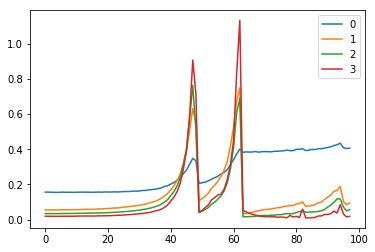

In [270]:
for h in hooks:
    plt.plot(h.stats[0])
    h.remove()
plt.legend(range(4));

### A Hooks class

Let's design our own class that can contain a list of objects. It will behave a bit like a numpy array in the sense that we can index into it via:
- a single index
- a slice (like 1:5)
- a list of indices
- a mask of indices (`[True,False,False,True,...]`)

The `__iter__` method is there to be able to do things like `for x in ...`.

In [271]:
#export
class ListContainer():
    def __init__(self, items): 
        self.items = listify(items)
    #gets called when use []
    def __getitem__(self, idx):
        try: 
            return self.items[idx]
        except TypeError:
            if isinstance(idx[0],bool):
                assert len(idx)==len(self) # bool mask
                return [o for m,o in zip(idx,self.items) if m]
            return [self.items[i] for i in idx]
    def __len__(self): 
        return len(self.items)
    def __iter__(self): 
        return iter(self.items)
    def __setitem__(self, i, o): 
        self.items[i] = o
    def __delitem__(self, i): 
        del(self.items[i])
    def __repr__(self):
        res = f'{self.__class__.__name__} ({len(self)} items)\n{self.items[:10]}'
        if len(self)>10: 
            res = res[:-1]+ '...]'
        return res

In [272]:
ListContainer(range(10))

ListContainer (10 items)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [273]:
ListContainer(range(100))

ListContainer (100 items)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9...]

In [274]:
t = ListContainer(range(10))
t[[1,2]], t[[False]*8 + [True,False]]

([1, 2], [8])

In [275]:
t[tensor(3)]

3

We can use it to write a `Hooks` class that contains several hooks. We will also use it in the next notebook as a container for our objects in the data block API.

In [276]:
#export
from torch.nn import init

class Hooks(ListContainer):
    def __init__(self, ms, f): 
        #call hook for every module in some list of modules
        super().__init__([Hook(m, f) for m in ms])
    def __enter__(self, *args): 
        return self
    def __exit__ (self, *args): 
        self.remove()
    def __del__(self): 
        self.remove()

    def __delitem__(self, i):
        self[i].remove()
        super().__delitem__(i)
        
    def remove(self):
        for h in self: h.remove()

In [277]:
model = get_cnn_model(data, nfs).cuda()
learn,run = get_runner(model, data, lr=0.9, cbs=cbfs)

BatchTransformXCallback.__init__() tfm: <function view_tfm.<locals>._inner at 0x7f16684f5e18>


In [278]:
hooks = Hooks(model, append_stats)
hooks

Hooks (7 items)
[<__main__.Hook object at 0x7f166842a5c0>, <__main__.Hook object at 0x7f166842a208>, <__main__.Hook object at 0x7f166859a198>, <__main__.Hook object at 0x7f166859a7f0>, <__main__.Hook object at 0x7f166859a4e0>, <__main__.Hook object at 0x7f166859ae10>, <__main__.Hook object at 0x7f166859a3c8>]

In [279]:
hooks.remove()

In [280]:
x,y = next(iter(data.train_dl))
x = mnist_resize(x).cuda()

In [281]:
x.mean(),x.std()

(tensor(0.0173, device='cuda:0'), tensor(1.0179, device='cuda:0'))

Pass through first layer of model (conv) note mean closeish to zero, std dev fair but less than 1

In [282]:
p = model[0](x)
p.mean(),p.std()

(tensor(0.2034, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.3515, device='cuda:0', grad_fn=<StdBackward0>))

In [283]:
for l in model:
    if isinstance(l, nn.Sequential):
        init.kaiming_normal_(l[0].weight)
        l[0].bias.data.zero_()

after kaiming norm mean close to 0.5 (relu) and std dev close to 1

In [284]:
p = model[0](x)
p.mean(),p.std()

(tensor(0.3750, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.6818, device='cuda:0', grad_fn=<StdBackward0>))

Having given an `__enter__` and `__exit__` method to our `Hooks` class, we can use it as a context manager. This makes sure that once we are out of the `with` block, all the hooks have been removed and aren't there to pollute our memory.

Note the with block - calls the `__enter__` and `__exit__` methods in Hooks

func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1])

func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1])

func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1])

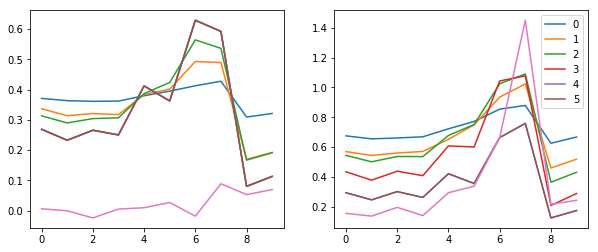

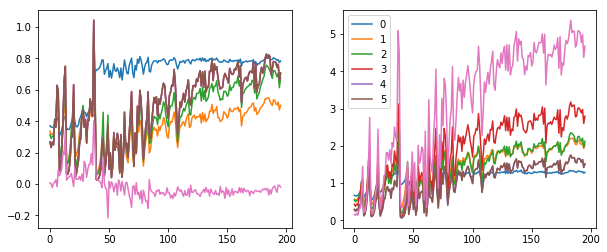

In [285]:
with Hooks(model, append_stats) as hooks:
    run.fit(2, learn)
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss = h.stats
        #plot 1st 10 mean and std dev
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
    plt.legend(range(6));
    
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        #plot all
        ms,ss = h.stats
        ax0.plot(ms)
        ax1.plot(ss)
    plt.legend(range(6));

### Other statistics

Let's store more than the means and stds and plot histograms of our activations now.

hitogram of acts

In [286]:
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook,'stats'): 
        hook.stats = ([],[],[])
    means,stds,hists = hook.stats
    if mod.training:
        means.append(outp.data.mean().cpu())
        stds .append(outp.data.std().cpu())
        hists.append(outp.data.cpu().histc(40,0,10)) #histc isn't implemented on the GPU

In [287]:
model = get_cnn_model(data, nfs).cuda()
#note high lr
learn,run = get_runner(model, data, lr=0.9, cbs=cbfs)

BatchTransformXCallback.__init__() tfm: <function view_tfm.<locals>._inner at 0x7f16684f5e18>


In [288]:
for l in model:
    if isinstance(l, nn.Sequential):
        init.kaiming_normal_(l[0].weight)
        l[0].bias.data.zero_()

In [289]:
with Hooks(model, append_stats) as hooks: run.fit(1, learn)

func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1])

func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1])

In [290]:
# Thanks to @ste for initial version of histogram plotting code
def get_hist(h): 
    return torch.stack(h.stats[2]).t().float().log1p()

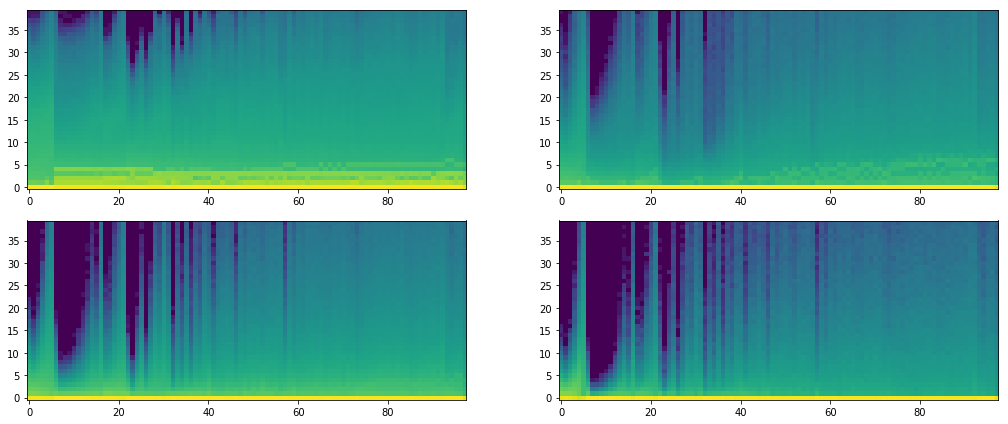

In [291]:
fig,axes = plt.subplots(2,2, figsize=(15,6))
for ax,h in zip(axes.flatten(), hooks[:4]):
    ax.imshow(get_hist(h), origin='lower')
    #ax.axis('off')
    ax.axis('on')
plt.tight_layout()

From the histograms, we can easily get more informations like the min or max of the activations

In [292]:
def get_min(h):
    h1 = torch.stack(h.stats[2]).t().float()
    print(f'--get_min() h1.shape: {h1.shape}')
    #number of zero in first 2 bins / sum of num zeros in all bins
    return h1[:2].sum(0)/h1.sum(0)

--get_min() h1.shape: torch.Size([40, 98])
--get_min() h1.shape: torch.Size([40, 98])
--get_min() h1.shape: torch.Size([40, 98])
--get_min() h1.shape: torch.Size([40, 98])


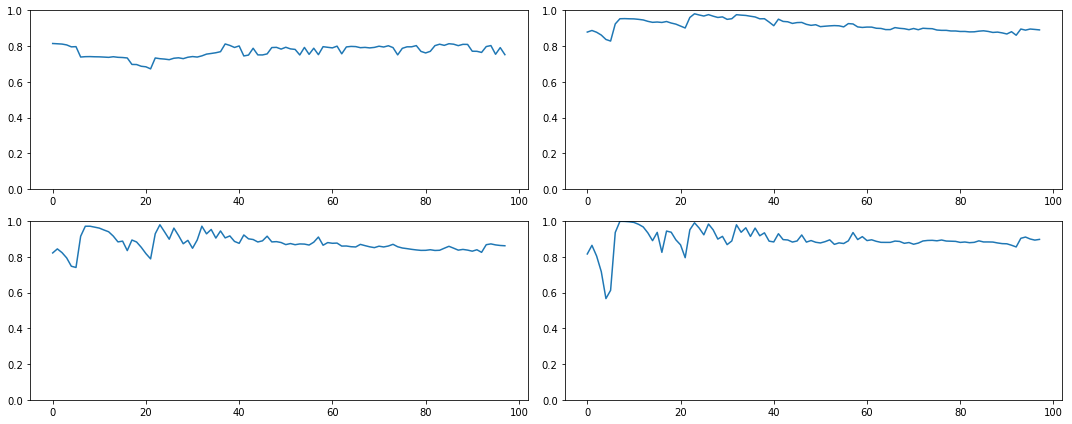

In [293]:
fig,axes = plt.subplots(2,2, figsize=(15,6))
for ax,h in zip(axes.flatten(), hooks[:4]):
    ax.plot(get_min(h))
    ax.set_ylim(0,1)
plt.tight_layout()

Note in last layer above >90% activations are zero - big problem

## Generalized ReLU

Now let's use our model with a generalized ReLU that can be shifted and with maximum value.

In [294]:
#export
#note **kwargs so end up passed to generalised relu
def get_cnn_layers(data, nfs, layer, **kwargs):
    nfs = [1] + nfs
    return [layer(nfs[i], nfs[i+1], 5 if i==0 else 3, **kwargs)
            for i in range(len(nfs)-1)] + [
        nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], data.c)]

def conv_layer(ni, nf, ks=3, stride=2, **kwargs):
    return nn.Sequential(
        nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride), GeneralRelu(**kwargs))

#main trick
#pass in ammt to subtr from relu, leaky relu, opt max val.
class GeneralRelu(nn.Module):
    def __init__(self, leak=None, sub=None, maxv=None):
        super().__init__()
        self.leak,self.sub,self.maxv = leak,sub,maxv

    def forward(self, x): 
        if self.leak is not None:
            print('--forward() using leaky relu')
            x = F.leaky_relu(x,self.leak) 
        else:
            x = F.relu(x)
        if self.sub is not None: 
            print(f'--forward() using sub{ self.sub}')
            x.sub_(self.sub)
        if self.maxv is not None: 
            print(f'--forward() using maxv {self.maxv}')
            x.clamp_max_(self.maxv)
        return x

def init_cnn(m, uniform=False):
    #lot of ppl think uniform better than normal, but no paper (known) to show this is correct
    f = init.kaiming_uniform_ if uniform else init.kaiming_normal_
    for l in m:
        if isinstance(l, nn.Sequential):
            f(l[0].weight, a=0.1)
            l[0].bias.data.zero_()

def get_cnn_model(data, nfs, layer, **kwargs):
    return nn.Sequential(*get_cnn_layers(data, nfs, layer, **kwargs))

In [295]:
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook,'stats'): 
        hook.stats = ([],[],[])
    means,stds,hists = hook.stats
    if mod.training:
        means.append(outp.data.mean().cpu())
        stds .append(outp.data.std().cpu())
        #as leaky relu and can subtr, change hist scale
        hists.append(outp.data.cpu().histc(40,-7,7))

In [296]:
#using leaky rely, subtract 0.4 (with leaky relu can subtr bit less than half) and max
model =  get_cnn_model(data, nfs, conv_layer, leak=0.1, sub=0.4, maxv=6.)
init_cnn(model)
learn,run = get_runner(model, data, lr=0.9, cbs=cbfs)

BatchTransformXCallback.__init__() tfm: <function view_tfm.<locals>._inner at 0x7f16684f5e18>


--forward() using leaky relu
--forward() using sub0.4
--forward() using maxv 6.0
--forward() using leaky relu
--forward() using sub0.4
--forward() using maxv 6.0
--forward() using leaky relu
--forward() using sub0.4
--forward() using maxv 6.0
--forward() using leaky relu
--forward() using sub0.4
--forward() using maxv 6.0
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
--forward() using leaky relu
--forward() using sub0.4
--forward() using maxv 6.0
--forward() using leaky relu
--forward() using sub0.4
--forward() using maxv 6.0
--forward() using leaky relu
--forward() using sub0.4
--forward() using maxv 6.0
--forward() using leaky relu
--forward() using sub0.4
--forward() using maxv 6.0
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
--forward() using leaky relu
--forward() using sub0.4
--forward() using maxv 6.0
--forward() using leaky relu
--forward() 

--forward() using leaky relu
--forward() using sub0.4
--forward() using maxv 6.0
--forward() using leaky relu
--forward() using sub0.4
--forward() using maxv 6.0
--forward() using leaky relu
--forward() using sub0.4
--forward() using maxv 6.0
--forward() using leaky relu
--forward() using sub0.4
--forward() using maxv 6.0
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
--forward() using leaky relu
--forward() using sub0.4
--forward() using maxv 6.0
--forward() using leaky relu
--forward() using sub0.4
--forward() using maxv 6.0
--forward() using leaky relu
--forward() using sub0.4
--forward() using maxv 6.0
--forward() using leaky relu
--forward() using sub0.4
--forward() using maxv 6.0
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
--forward() using leaky relu
--forward() using sub0.4
--forward() using maxv 6.0
--forward() using leaky relu
--forward() 

--forward() using maxv 6.0
--forward() using leaky relu
--forward() using sub0.4
--forward() using maxv 6.0
--forward() using leaky relu
--forward() using sub0.4
--forward() using maxv 6.0
--forward() using leaky relu
--forward() using sub0.4
--forward() using maxv 6.0
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
--forward() using leaky relu
--forward() using sub0.4
--forward() using maxv 6.0
--forward() using leaky relu
--forward() using sub0.4
--forward() using maxv 6.0
--forward() using leaky relu
--forward() using sub0.4
--forward() using maxv 6.0
--forward() using leaky relu
--forward() using sub0.4
--forward() using maxv 6.0
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
--forward() using leaky relu
--forward() using sub0.4
--forward() using maxv 6.0
--forward() using leaky relu
--forward() using sub0.4
--forward() using maxv 6.0
--forward() us

--forward() using leaky relu
--forward() using sub0.4
--forward() using maxv 6.0
--forward() using leaky relu
--forward() using sub0.4
--forward() using maxv 6.0
--forward() using leaky relu
--forward() using sub0.4
--forward() using maxv 6.0
--forward() using leaky relu
--forward() using sub0.4
--forward() using maxv 6.0
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
--forward() using leaky relu
--forward() using sub0.4
--forward() using maxv 6.0
--forward() using leaky relu
--forward() using sub0.4
--forward() using maxv 6.0
--forward() using leaky relu
--forward() using sub0.4
--forward() using maxv 6.0
--forward() using leaky relu
--forward() using sub0.4
--forward() using maxv 6.0
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
--forward() using leaky relu
--forward() using sub0.4
--forward() using maxv 6.0
--forward() using leaky relu
--forward() 

--forward() using sub0.4
--forward() using maxv 6.0
--forward() using leaky relu
--forward() using sub0.4
--forward() using maxv 6.0
--forward() using leaky relu
--forward() using sub0.4
--forward() using maxv 6.0
--forward() using leaky relu
--forward() using sub0.4
--forward() using maxv 6.0
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
--forward() using leaky relu
--forward() using sub0.4
--forward() using maxv 6.0
--forward() using leaky relu
--forward() using sub0.4
--forward() using maxv 6.0
--forward() using leaky relu
--forward() using sub0.4
--forward() using maxv 6.0
--forward() using leaky relu
--forward() using sub0.4
--forward() using maxv 6.0
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
--forward() using leaky relu
--forward() using sub0.4
--forward() using maxv 6.0
--forward() using leaky relu
--forward() using sub0.4
--forward() usin

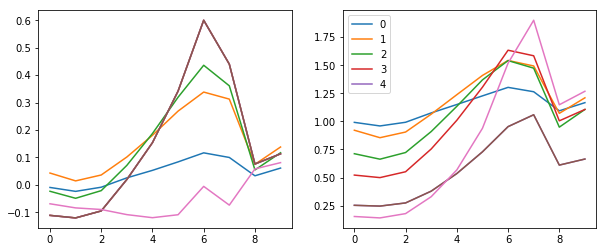

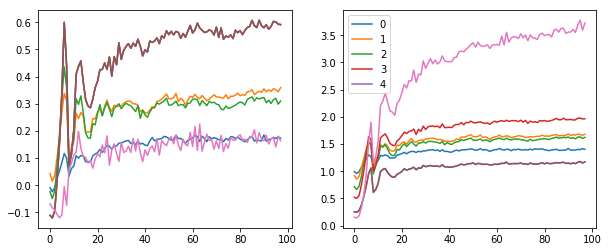

In [297]:
with Hooks(model, append_stats) as hooks:
    run.fit(1, learn)
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss,hi = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
    plt.legend(range(5));
    
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss,hi = h.stats
        ax0.plot(ms)
        ax1.plot(ss)
    plt.legend(range(5));

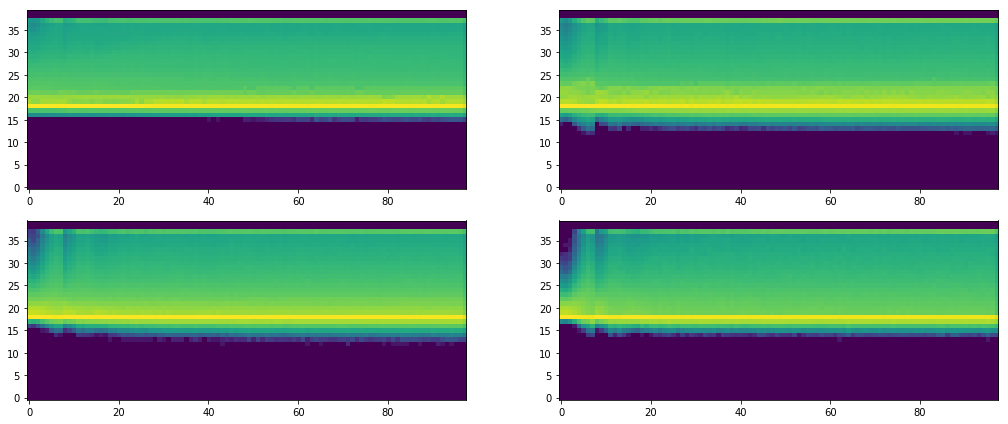

In [298]:
fig,axes = plt.subplots(2,2, figsize=(15,6))
for ax,h in zip(axes.flatten(), hooks[:4]):
    ax.imshow(get_hist(h), origin='lower')
    ax.axis('on')
plt.tight_layout()

In [299]:
def get_min(h):
    h1 = torch.stack(h.stats[2]).t().float()
    #change this fn so that get stats on middle bins of hist rather than first 2
    return h1[19:22].sum(0)/h1.sum(0)

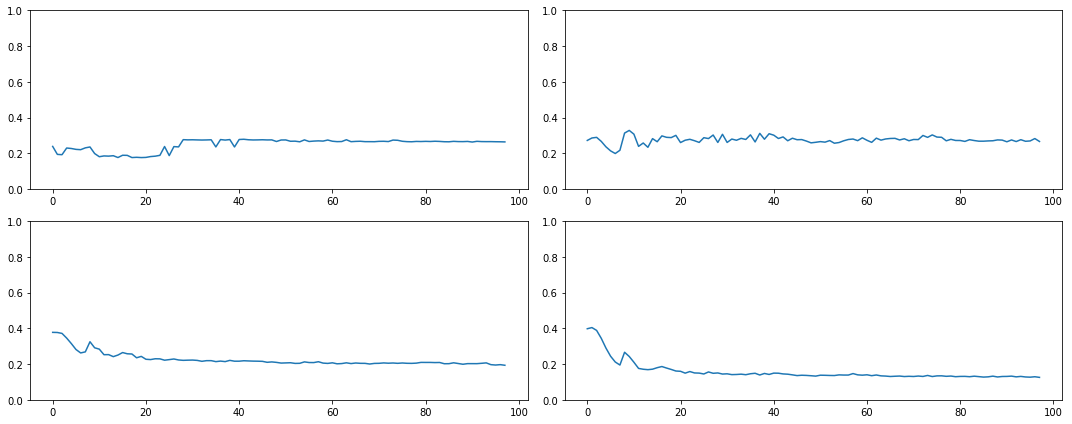

In [300]:
fig,axes = plt.subplots(2,2, figsize=(15,6))
for ax,h in zip(axes.flatten(), hooks[:4]):
    ax.plot(get_min(h))
    ax.set_ylim(0,1)
plt.tight_layout()

Note much better - only 20% of final activations are zeo

y num activations at value

In [302]:
#export
def get_learn_run(nfs, data, lr, layer, cbs=None, opt_func=None, uniform=False, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model, uniform=uniform)
    return get_runner(model, data, lr=lr, cbs=cbs, opt_func=opt_func)

In [303]:
#2 phases, gradual w/u, gradual cool down

In [304]:
sched = combine_scheds([0.5, 0.5], [sched_cos(0.2, 1.), sched_cos(1., 0.1)]) 

In [305]:
learn,run = get_learn_run(nfs, data, 1., conv_layer, cbs=cbfs+[partial(ParamScheduler,'lr', sched)])

BatchTransformXCallback.__init__() tfm: <function view_tfm.<locals>._inner at 0x7f16684f5e18>


In [306]:
run.fit(8, learn)

func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1])

func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1])

func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1])

func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1])

func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([1024, 32, 1, 1]), out shape: torch.Size([1024, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([1024, 32, 1, 1]), out shape: torch.Size([1024, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([1024, 32, 1, 1]), out shape: torch.Size([1024, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([1024, 32, 1, 1]), out shape: torch.Size([1024, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([1024, 32, 1, 1]), out shape: torch.Size([1024, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([1024, 32, 1, 1]), out shape: torch.Size([1024, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([1024, 32, 1, 1]), out shape: torch.Size([1024, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([784, 32, 1, 1]), out shape: torch.Size([784, 32])
train: [0.28598150390625, tensor(0.9118, device='cuda:0')]
valid: 

func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1])

func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1])

func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1])

func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1])

func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1])

func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1])

Uniform init may provide more useful initial weights (normal distribution puts a lot of them at 0).

In [309]:
learn,run = get_learn_run(nfs, data, 1., conv_layer, uniform=True,
                          cbs=cbfs+[partial(ParamScheduler,'lr', sched)])

BatchTransformXCallback.__init__() tfm: <function view_tfm.<locals>._inner at 0x7f16684f5e18>


<pre>
uniform=False:
train: [0.038191728515625, tensor(0.9881, device='cuda:0')]
valid: [0.06315469970703125, tensor(0.9817, device='cuda:0')]

uniform=True:
train: [0.0343764404296875, tensor(0.9901, device='cuda:0')]
valid: [0.0577570556640625, tensor(0.9835, device='cuda:0')]
</pre>

In [310]:
run.fit(8, learn)

func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1])

func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1])

func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1])

func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1])

func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([336, 32, 1, 1]), out shape: torch.Size([336, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([1024, 32, 1, 1]), out shape: torch.Size([1024, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([1024, 32, 1, 

func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1])

func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1])

func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1])

in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <f

func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1])

func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1]), out shape: torch.Size([512, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([512, 32, 1, 1])

func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([1024, 32, 1, 1]), out shape: torch.Size([1024, 32])
func: <function flatten at 0x7f16681a3d08>
in shape: torch.Size([784, 32, 1, 1]), out shape: torch.Size([784, 32])
train: [0.0343764404296875, tensor(0.9901, device='cuda:0')]
valid: [0.0577570556640625, tensor(0.9835, device='cuda:0')]


## Export

Here's a handy way to export our module without needing to update the file name - after we define this, we can just use `nb_auto_export()` in the future (h/t Stas Bekman):

In [88]:
#export
from IPython.display import display, Javascript
def nb_auto_export():
    display(Javascript("""{
const ip = IPython.notebook
if (ip) {
    ip.save_notebook()
    console.log('a')
    const s = `!python notebook2script.py ${ip.notebook_name}`
    if (ip.kernel) { ip.kernel.execute(s) }
}
}"""))

In [89]:
#nb_auto_export()